In [30]:
import numpy as np
from numba import njit
import pickle
from sklearn.ensemble import BaggingClassifier
from sklearn.tree._classes import DecisionTreeClassifier
from joblib import Parallel, delayed
from scipy.stats import entropy, multivariate_normal

from hyppo.tools import multimodal_independence, indep_sim
from hyppo.ksample._utils import k_sample_transform
from tqdm import tqdm
from hyppo.tools import * 

import sys
import os
import multiprocessing as mp
from proglearn import UncertaintyForest
from joblib import Parallel, delayed
sys.path.append('C:\\Users\\siptest\\AppData\\Roaming\\Python\\Python36\\Scripts')

In [2]:
def test_stat_helper(vote_nodes, vote_classes, class_counts, K, kappa=3, base=2):
    """
    est_nodes : list
        Leaf indices used for voting
    eval_nodes : list
        Leaf indices in which a sample from the density subsample falls
    est_classes : list
        Voter class labels in est_node leaves
    """
    for i in range(len(vote_nodes)):
        class_counts[vote_nodes[i], vote_classes[i]] += 1

    # Total number of estimation points in each leaf.
    row_sums = class_counts.sum(axis=1)
    row_sums[row_sums == 0] = 1  # Avoid divide by zero.
    class_probs = class_counts / row_sums[:, None]

    # Make the nodes that have no estimation indices uniform.
    # This includes non-leaf nodes, but tha t will not affect the estimate.
    class_probs[np.argwhere(class_probs.sum(axis=1) == 0)] = [1 / K]*K
    # Apply finite sample correction and renormalize.
    where_0 = np.argwhere(class_probs == 0)
    for elem in where_0:
        class_probs[elem[0], elem[1]] = 1 / \
            (kappa*class_counts.sum(axis=1)[elem[0]])
    row_sums = class_probs.sum(axis=1)
    class_probs = class_probs / row_sums[:, None]

    # Place evaluation points in their corresponding leaf node.
    # Store evaluation posterior in a num_eval-by-num_class matrix.
    vote_class_probs = class_probs[vote_nodes]
    vote_entropies = [entropy(posterior, base=base)
                      for posterior in vote_class_probs]
    return np.mean(vote_entropies)


In [3]:
def uf(X, y, n_estimators=5, max_samples=.63, base=2, kappa=3, reps=100, n_jobs=None):
    # Build forest with default parameters.
    model = BaggingClassifier(DecisionTreeClassifier(),
                              n_estimators=n_estimators,
                              max_samples=max_samples,
                              n_jobs=n_jobs,
                              bootstrap=False)
    model.fit(X, y)
    n = X.shape[0]
    K = model.n_classes_
    _, y = np.unique(y, return_inverse=True)

    cond_entropy = 0
    final_null_dist = [0] * 100

    #tree_est_nodes = []
    #tree_eval_nodes = []
    tree_vote_nodes = []
    tree_unsampled_indices = []

    # Get real test statistics
    for tree_idx, tree in enumerate(model):
        # Find the indices of the training set used for partition.
        sampled_indices = model.estimators_samples_[tree_idx]
        unsampled_indices = np.delete(np.arange(0, n), sampled_indices)
        np.random.shuffle(unsampled_indices)
        tree_unsampled_indices.append(unsampled_indices)

        # Randomly split the rest into voting and evaluation.
        #vote_indices = unsampled_indices[:len(unsampled_indices)//2]
        #eval_indices = unsampled_indices[len(unsampled_indices)//2:]

        # Store the posterior in a num_nodes-by-num_classes matrix.
        # Posteriors in non-leaf cells will be zero everywhere
        # and later changed to uniform.
        node_counts = tree.tree_.n_node_samples
        class_counts = np.zeros((len(node_counts), K))
        vote_nodes = tree.apply(X[unsampled_indices])
        tree_vote_nodes.append(vote_nodes)
        
        #est_nodes = tree.apply(X[vote_indices])
        #tree_est_nodes.append(est_nodes)
        #eval_nodes = tree.apply(X[eval_indices])
        #tree_eval_nodes.append(eval_nodes)

        cond_entropy += test_stat_helper(
            vote_nodes, y[unsampled_indices], class_counts, K)

    # Generate null dist
    # normally 1000-10,000 reps for null 
    for j in range(reps):
        for tree, unsampled_indices, vote_nodes in zip(
            model, tree_unsampled_indices, tree_vote_nodes
        ):
            node_counts = tree.tree_.n_node_samples
            class_counts = np.zeros((len(node_counts), K))
            y_vote = y[unsampled_indices]
            np.random.shuffle(y_vote)
            final_null_dist[j] += test_stat_helper(
                vote_nodes, y_vote, class_counts, K)

    # note: shuffling y doesn't change these outputs
    new_final_null_dist = [entropy([np.mean(
        y), 1 - np.mean(y)], base=2) - val / n_estimators for val in final_null_dist]

    final_stat = entropy([np.mean(y), 1 - np.mean(y)],
                         base=2) - cond_entropy / n_estimators
    return final_stat, new_final_null_dist

In [ ]:
def ce(X): return entropy(X, axis=1, base = np.exp(1))
uf = UncertaintyForest(n_estimators = 5, 
                       tree_construction_proportion=0.63, 
                       kappa = 3/2, 
                       honest_prior = "ignore", 
                       max_features = 1.0, 
                       n_jobs=-2,
                      )

matrix1, matrix2 = multimodal_independence(n_samples, 2)
X, y = k_sample_transform([matrix1, matrix2])

def func(x):
        p = 0.5 * norm.pdf(x, mu, 1) + 0.5 * norm.pdf(x, -mu, 1)
        return -p * np.log(p) / np.log(base)
    
# calculate norm factor - need compute_mutual_info & make_params

_, counts = np.unique(y, return_counts=True)
est_H_Y = entropy(counts, base=np.exp(1))
value = (est_H_Y - uf.fit(X, y).apply_oob(X, ce)) / norm_factor

In [33]:
MAX_SAMPLE_SIZE = 500
STEP_SIZE = 100 
SAMP_SIZES = range(100, MAX_SAMPLE_SIZE + STEP_SIZE, STEP_SIZE)
POWER_REPS = 20

SIMULATIONS = [
    # "linear": "Linear",
    # "multimodal_independence": "Independence"
    # linear,
    multimodal_independence
]

In [38]:
from statsmodels.distributions.empirical_distribution import ECDF
import matplotlib.pyplot as plt
def estimate_power(sim, n_jobs=None):
    samp_size_dict = dict()
    samp_size_dict['sample_sizes'] = SAMP_SIZES
    samp_size_dict['n_power_reps'] = POWER_REPS
    power = []
    pvalues_list = []
    for n_samples in SAMP_SIZES:
        pvalues = []
        samp_size_dict[n_samples] = {'stats': [], 'null_dists': []}
        for p in tqdm(range(POWER_REPS)):
            #plt.clf()
            np.random.seed(None)
            #matrix1, matrix2 = multimodal_independence(n_samples, 2)
            #x, y = k_sample_transform([matrix1, matrix2])
            x, y = linear(n_samples, 2)
            y = list(map(lambda sub: list(map(int, sub)), y))
            stat, null_dist = uf(x, y, n_jobs=n_jobs)
            #stat, null_dist = uf(x, y.ravel(), n_jobs=n_jobs)
            samp_size_dict[n_samples]['stats'].append(stat)
            samp_size_dict[n_samples]['null_dists'].append(null_dist)
            pvalue = np.mean(np.asarray(null_dist) >= stat)
            print("P-value: " + str(pvalue))
            print(f'Test stat: {stat}')
            print(f'Null dist: {null_dist[:5]}')
            #if p % 4 == 0: 
                #plt.hist(null_dist)
                #plt.axvline(stat, c='r', ls='--')
            #plt.show()
            pvalues.append(pvalue)
        pvalues_list.append(pvalues)
        #plt.hist(pvalues, range=(0,1))
        #plt.show()
        axes = plt.gca()
        x_vals = np.array(axes.get_xlim())
        y_vals = 1 * x_vals
        plt.plot(x_vals, y_vals, '--')
        ecdf = ECDF(pvalues)
        plt.plot(ecdf.x, ecdf.y)
        plt.gca().set_aspect('equal', adjustable='box')
        plt.xlabel("p-value")
        plt.xlim(0, 1)
        plt.ylim(0, 1)
        plt.ylabel("fraction of data")
        plt.show()
        power.append(np.mean(np.asarray(pvalues) <= 0.05))
        #power.append((pvalues >= 0.05).sum() / POWER_REPS)

    #with open('multimodal_independence_power_reps.pkl', 'wb') as handle:
        #pickle.dump(samp_size_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

    with open('linear_power_reps.pkl', 'wb') as handle:
        pickle.dump(samp_size_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)
        
    np.savetxt('C:/Users/siptest/Desktop/NDD/linear_honest_3-31.csv',
               power, delimiter=',')

    return power, pvalues_list

  0%|                                                                                           | 0/20 [00:00<?, ?it/s]C:\Users\siptest\anaconda3\envs\py36\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
  5%|████▏                                                                              | 1/20 [00:03<01:07,  3.53s/it]

P-value: 0.0
Test stat: -0.41951304512277215
Null dist: [-0.5392840606292736, -0.5299996829186377, -0.49824340268638717, -0.5462506318743725, -0.5151434494792093]


C:\Users\siptest\anaconda3\envs\py36\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
 10%|████████▎                                                                          | 2/20 [00:04<00:47,  2.64s/it]

P-value: 0.0
Test stat: -0.24037782384914497
Null dist: [-0.40930972205613986, -0.40990799739644906, -0.38097912255184146, -0.40965639402202053, -0.39345764101646]


C:\Users\siptest\anaconda3\envs\py36\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
 15%|████████████▍                                                                      | 3/20 [00:04<00:34,  2.01s/it]

P-value: 1.0
Test stat: -inf
Null dist: [-inf, -inf, -inf, -inf, -inf]


C:\Users\siptest\anaconda3\envs\py36\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
 20%|████████████████▌                                                                  | 4/20 [00:05<00:24,  1.56s/it]

P-value: 0.0
Test stat: -0.23395252035389918
Null dist: [-0.3107318005827903, -0.35217254008541243, -0.37610538794528675, -0.36030480130628834, -0.3842105101851772]


C:\Users\siptest\anaconda3\envs\py36\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
 25%|████████████████████▊                                                              | 5/20 [00:05<00:18,  1.25s/it]

P-value: 1.0
Test stat: -inf
Null dist: [-inf, -inf, -inf, -inf, -inf]


C:\Users\siptest\anaconda3\envs\py36\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
 30%|████████████████████████▉                                                          | 6/20 [00:06<00:14,  1.06s/it]

P-value: 0.0
Test stat: -0.30658729702844584
Null dist: [-0.43374065582786286, -0.45314055337426057, -0.4821424328035567, -0.4276154083948109, -0.4823627163738137]


C:\Users\siptest\anaconda3\envs\py36\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
 35%|█████████████████████████████                                                      | 7/20 [00:06<00:12,  1.07it/s]

P-value: 1.0
Test stat: -inf
Null dist: [-inf, -inf, -inf, -inf, -inf]


C:\Users\siptest\anaconda3\envs\py36\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
 40%|█████████████████████████████████▏                                                 | 8/20 [00:07<00:09,  1.24it/s]

P-value: 1.0
Test stat: -inf
Null dist: [-inf, -inf, -inf, -inf, -inf]


C:\Users\siptest\anaconda3\envs\py36\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
 45%|█████████████████████████████████████▎                                             | 9/20 [00:07<00:07,  1.38it/s]

P-value: 0.0
Test stat: -0.2478147997606659
Null dist: [-0.489073589873365, -0.5254951446410739, -0.46465816430419127, -0.48669676869768175, -0.5059046620478884]


C:\Users\siptest\anaconda3\envs\py36\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
 50%|█████████████████████████████████████████                                         | 10/20 [00:08<00:06,  1.53it/s]

P-value: 1.0
Test stat: -inf
Null dist: [-inf, -inf, -inf, -inf, -inf]


C:\Users\siptest\anaconda3\envs\py36\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
 55%|█████████████████████████████████████████████                                     | 11/20 [00:08<00:05,  1.65it/s]

P-value: 0.0
Test stat: -0.11486476134238333
Null dist: [-0.3448061949436383, -0.35440884097246084, -0.28269126362288866, -0.32815759341409867, -0.33732750925512556]


C:\Users\siptest\anaconda3\envs\py36\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
 60%|█████████████████████████████████████████████████▏                                | 12/20 [00:09<00:04,  1.73it/s]

P-value: 0.0
Test stat: -0.4110288647376107
Null dist: [-0.663086018107907, -0.6595967137323075, -0.5971815777532513, -0.6664670193222557, -0.6892488177340651]


C:\Users\siptest\anaconda3\envs\py36\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
 65%|█████████████████████████████████████████████████████▎                            | 13/20 [00:09<00:03,  1.79it/s]

P-value: 0.0
Test stat: -0.15067954824524915
Null dist: [-0.3778853726682259, -0.3503773078448677, -0.388701847480503, -0.39976485891692787, -0.37567399039879296]


C:\Users\siptest\anaconda3\envs\py36\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
 70%|█████████████████████████████████████████████████████████▍                        | 14/20 [00:10<00:03,  1.83it/s]

P-value: 0.0
Test stat: -0.5759803982104768
Null dist: [-0.7060646474519562, -0.6907596399029601, -0.6785761773694521, -0.7162910337611776, -0.6863839376460591]


C:\Users\siptest\anaconda3\envs\py36\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
 75%|█████████████████████████████████████████████████████████████▌                    | 15/20 [00:10<00:02,  1.90it/s]

P-value: 0.0
Test stat: -0.3290747909260826
Null dist: [-0.4937867654238556, -0.43142551629582204, -0.45028783220211166, -0.4349402220873656, -0.4033415782456765]


C:\Users\siptest\anaconda3\envs\py36\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
 80%|█████████████████████████████████████████████████████████████████▌                | 16/20 [00:11<00:02,  1.92it/s]

P-value: 1.0
Test stat: -inf
Null dist: [-inf, -inf, -inf, -inf, -inf]


C:\Users\siptest\anaconda3\envs\py36\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
 85%|█████████████████████████████████████████████████████████████████████▋            | 17/20 [00:11<00:01,  1.95it/s]

P-value: 0.0
Test stat: -0.5064769778156449
Null dist: [-0.588763471587896, -0.5908120950415268, -0.5605164473902502, -0.5584497801888408, -0.5953034506194963]


C:\Users\siptest\anaconda3\envs\py36\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:12<00:01,  1.99it/s]

P-value: 1.0
Test stat: -inf
Null dist: [-inf, -inf, -inf, -inf, -inf]


C:\Users\siptest\anaconda3\envs\py36\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
 95%|█████████████████████████████████████████████████████████████████████████████▉    | 19/20 [00:12<00:00,  2.01it/s]

P-value: 0.0
Test stat: -0.4126652479570652
Null dist: [-0.6731640648942875, -0.6417841377401001, -0.7124577727167802, -0.6609895421003192, -0.7048957627045631]


C:\Users\siptest\anaconda3\envs\py36\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:13<00:00,  1.49it/s]

P-value: 0.0
Test stat: -0.2766999756923232
Null dist: [-0.46493623623431135, -0.4520116805492914, -0.4895584204310053, -0.4613955520115457, -0.4121060526959017]


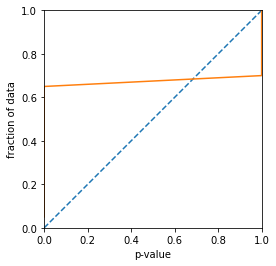

  0%|                                                                                           | 0/20 [00:00<?, ?it/s]C:\Users\siptest\anaconda3\envs\py36\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
  5%|████▏                                                                              | 1/20 [00:01<00:19,  1.05s/it]

P-value: 1.0
Test stat: -inf
Null dist: [-inf, -inf, -inf, -inf, -inf]


C:\Users\siptest\anaconda3\envs\py36\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
 10%|████████▎                                                                          | 2/20 [00:02<00:19,  1.09s/it]

P-value: 0.0
Test stat: -0.33259458933242525
Null dist: [-0.6852672590710118, -0.7124844159450141, -0.6943492577728301, -0.691288577107348, -0.699400013572067]


C:\Users\siptest\anaconda3\envs\py36\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
 15%|████████████▍                                                                      | 3/20 [00:03<00:21,  1.25s/it]

P-value: 1.0
Test stat: -inf
Null dist: [-inf, -inf, -inf, -inf, -inf]


C:\Users\siptest\anaconda3\envs\py36\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
 20%|████████████████▌                                                                  | 4/20 [00:05<00:19,  1.22s/it]

P-value: 1.0
Test stat: -inf
Null dist: [-inf, -inf, -inf, -inf, -inf]


C:\Users\siptest\anaconda3\envs\py36\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
 25%|████████████████████▊                                                              | 5/20 [00:05<00:17,  1.15s/it]

P-value: 1.0
Test stat: -inf
Null dist: [-inf, -inf, -inf, -inf, -inf]


C:\Users\siptest\anaconda3\envs\py36\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
 30%|████████████████████████▉                                                          | 6/20 [00:07<00:16,  1.16s/it]

P-value: 1.0
Test stat: -inf
Null dist: [-inf, -inf, -inf, -inf, -inf]


C:\Users\siptest\anaconda3\envs\py36\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
 35%|█████████████████████████████                                                      | 7/20 [00:09<00:20,  1.59s/it]

P-value: 1.0
Test stat: -inf
Null dist: [-inf, -inf, -inf, -inf, -inf]


C:\Users\siptest\anaconda3\envs\py36\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
 40%|█████████████████████████████████▏                                                 | 8/20 [00:11<00:19,  1.64s/it]

P-value: 0.0
Test stat: -0.2581771885434795
Null dist: [-0.4831800910250087, -0.5128696457029868, -0.48272311614307595, -0.4950547609429796, -0.4890272059377908]


C:\Users\siptest\anaconda3\envs\py36\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
 45%|█████████████████████████████████████▎                                             | 9/20 [00:12<00:16,  1.48s/it]

P-value: 1.0
Test stat: -inf
Null dist: [-inf, -inf, -inf, -inf, -inf]


C:\Users\siptest\anaconda3\envs\py36\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
 50%|█████████████████████████████████████████                                         | 10/20 [00:13<00:14,  1.42s/it]

P-value: 0.0
Test stat: -0.3771806723707534
Null dist: [-0.6420364216235297, -0.6138466872826601, -0.6482817429524459, -0.6180603299061327, -0.6357080655589766]


C:\Users\siptest\anaconda3\envs\py36\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
 55%|█████████████████████████████████████████████                                     | 11/20 [00:14<00:11,  1.28s/it]

P-value: 0.0
Test stat: -0.14782737390415213
Null dist: [-0.40070263127779254, -0.3945584290167427, -0.3816260683221922, -0.37125759158865596, -0.3763795243686598]


C:\Users\siptest\anaconda3\envs\py36\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
 60%|█████████████████████████████████████████████████▏                                | 12/20 [00:15<00:09,  1.17s/it]

P-value: 1.0
Test stat: -inf
Null dist: [-inf, -inf, -inf, -inf, -inf]


C:\Users\siptest\anaconda3\envs\py36\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
 65%|█████████████████████████████████████████████████████▎                            | 13/20 [00:16<00:08,  1.14s/it]

P-value: 0.0
Test stat: -0.4660591137105235
Null dist: [-0.751824299373513, -0.7657408155121989, -0.7906010102654675, -0.767575436447171, -0.7599692990060354]


C:\Users\siptest\anaconda3\envs\py36\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
 70%|█████████████████████████████████████████████████████████▍                        | 14/20 [00:17<00:06,  1.12s/it]

P-value: 1.0
Test stat: -inf
Null dist: [-inf, -inf, -inf, -inf, -inf]


C:\Users\siptest\anaconda3\envs\py36\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
 75%|█████████████████████████████████████████████████████████████▌                    | 15/20 [00:20<00:07,  1.42s/it]

P-value: 1.0
Test stat: -inf
Null dist: [-inf, -inf, -inf, -inf, -inf]


C:\Users\siptest\anaconda3\envs\py36\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
 80%|█████████████████████████████████████████████████████████████████▌                | 16/20 [00:22<00:06,  1.58s/it]

P-value: 0.0
Test stat: -0.24898061574241015
Null dist: [-0.6023294717875263, -0.5675929336591681, -0.5809440128590876, -0.6067344380754268, -0.6196522685680925]


C:\Users\siptest\anaconda3\envs\py36\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
 85%|█████████████████████████████████████████████████████████████████████▋            | 17/20 [00:23<00:04,  1.41s/it]

P-value: 1.0
Test stat: -inf
Null dist: [-inf, -inf, -inf, -inf, -inf]


C:\Users\siptest\anaconda3\envs\py36\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:24<00:03,  1.52s/it]

P-value: 1.0
Test stat: -inf
Null dist: [-inf, -inf, -inf, -inf, -inf]


C:\Users\siptest\anaconda3\envs\py36\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
 95%|█████████████████████████████████████████████████████████████████████████████▉    | 19/20 [00:25<00:01,  1.36s/it]

P-value: 0.0
Test stat: -0.33793495322942974
Null dist: [-0.6080004011953887, -0.5850372854414564, -0.597663977132945, -0.5865792251281862, -0.5455440011619577]


C:\Users\siptest\anaconda3\envs\py36\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:27<00:00,  1.35s/it]

P-value: 0.0
Test stat: -0.46372891435019553
Null dist: [-0.7275285972170719, -0.6805376561460296, -0.6679454089026714, -0.6504561814052272, -0.6995837312273122]


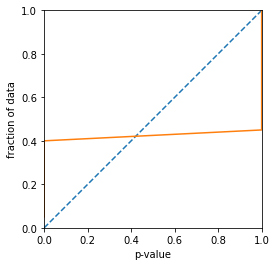

  0%|                                                                                           | 0/20 [00:00<?, ?it/s]C:\Users\siptest\anaconda3\envs\py36\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
  5%|████▏                                                                              | 1/20 [00:01<00:26,  1.37s/it]

P-value: 1.0
Test stat: -inf
Null dist: [-inf, -inf, -inf, -inf, -inf]


C:\Users\siptest\anaconda3\envs\py36\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
 10%|████████▎                                                                          | 2/20 [00:02<00:25,  1.40s/it]

P-value: 1.0
Test stat: -inf
Null dist: [-inf, -inf, -inf, -inf, -inf]


C:\Users\siptest\anaconda3\envs\py36\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
 15%|████████████▍                                                                      | 3/20 [00:04<00:22,  1.34s/it]

P-value: 1.0
Test stat: -inf
Null dist: [-inf, -inf, -inf, -inf, -inf]


C:\Users\siptest\anaconda3\envs\py36\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
 20%|████████████████▌                                                                  | 4/20 [00:05<00:20,  1.28s/it]

P-value: 1.0
Test stat: -inf
Null dist: [-inf, -inf, -inf, -inf, -inf]


C:\Users\siptest\anaconda3\envs\py36\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
 25%|████████████████████▊                                                              | 5/20 [00:06<00:19,  1.27s/it]

P-value: 1.0
Test stat: -inf
Null dist: [-inf, -inf, -inf, -inf, -inf]


C:\Users\siptest\anaconda3\envs\py36\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
 30%|████████████████████████▉                                                          | 6/20 [00:07<00:17,  1.27s/it]

P-value: 0.0
Test stat: -0.14529552291838393
Null dist: [-0.4894052409901851, -0.4856855305571849, -0.5221623675687044, -0.484982814910632, -0.4970080515720743]


C:\Users\siptest\anaconda3\envs\py36\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
 35%|█████████████████████████████                                                      | 7/20 [00:08<00:16,  1.25s/it]

P-value: 1.0
Test stat: -inf
Null dist: [-inf, -inf, -inf, -inf, -inf]


C:\Users\siptest\anaconda3\envs\py36\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
 40%|█████████████████████████████████▏                                                 | 8/20 [00:10<00:14,  1.21s/it]

P-value: 1.0
Test stat: -inf
Null dist: [-inf, -inf, -inf, -inf, -inf]


C:\Users\siptest\anaconda3\envs\py36\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
 45%|█████████████████████████████████████▎                                             | 9/20 [00:11<00:13,  1.19s/it]

P-value: 1.0
Test stat: -inf
Null dist: [-inf, -inf, -inf, -inf, -inf]


C:\Users\siptest\anaconda3\envs\py36\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
 50%|█████████████████████████████████████████                                         | 10/20 [00:12<00:11,  1.18s/it]

P-value: 0.0
Test stat: -0.2662152343126359
Null dist: [-0.6487786132586107, -0.6507447147060476, -0.6657340755057906, -0.6476898440029005, -0.6375249531699778]


C:\Users\siptest\anaconda3\envs\py36\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
 55%|█████████████████████████████████████████████                                     | 11/20 [00:13<00:10,  1.18s/it]

P-value: 1.0
Test stat: -inf
Null dist: [-inf, -inf, -inf, -inf, -inf]


C:\Users\siptest\anaconda3\envs\py36\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
 60%|█████████████████████████████████████████████████▏                                | 12/20 [00:14<00:09,  1.19s/it]

P-value: 1.0
Test stat: -inf
Null dist: [-inf, -inf, -inf, -inf, -inf]


C:\Users\siptest\anaconda3\envs\py36\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
 65%|█████████████████████████████████████████████████████▎                            | 13/20 [00:15<00:08,  1.22s/it]

P-value: 0.0
Test stat: -0.36176416471566497
Null dist: [-0.6027095146432446, -0.6292905820113025, -0.6094047070752026, -0.593453606529257, -0.6034365238214786]


C:\Users\siptest\anaconda3\envs\py36\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
 70%|█████████████████████████████████████████████████████████▍                        | 14/20 [00:17<00:07,  1.19s/it]

P-value: 0.0
Test stat: -0.33700151101311976
Null dist: [-0.5919580328038241, -0.6123596744673943, -0.600996176746638, -0.5605155552050468, -0.6018774640707398]


C:\Users\siptest\anaconda3\envs\py36\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
 75%|█████████████████████████████████████████████████████████████▌                    | 15/20 [00:18<00:06,  1.21s/it]

P-value: 1.0
Test stat: -inf
Null dist: [-inf, -inf, -inf, -inf, -inf]


C:\Users\siptest\anaconda3\envs\py36\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
 80%|█████████████████████████████████████████████████████████████████▌                | 16/20 [00:19<00:04,  1.18s/it]

P-value: 1.0
Test stat: -inf
Null dist: [-inf, -inf, -inf, -inf, -inf]


C:\Users\siptest\anaconda3\envs\py36\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
 85%|█████████████████████████████████████████████████████████████████████▋            | 17/20 [00:20<00:03,  1.17s/it]

P-value: 1.0
Test stat: -inf
Null dist: [-inf, -inf, -inf, -inf, -inf]


C:\Users\siptest\anaconda3\envs\py36\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:21<00:02,  1.19s/it]

P-value: 0.0
Test stat: -0.20244022564798805
Null dist: [-0.4735811353694067, -0.4651720901555896, -0.4432391202517698, -0.48411532061007967, -0.4489402929950096]


C:\Users\siptest\anaconda3\envs\py36\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
 95%|█████████████████████████████████████████████████████████████████████████████▉    | 19/20 [00:23<00:01,  1.20s/it]

P-value: 1.0
Test stat: -inf
Null dist: [-inf, -inf, -inf, -inf, -inf]


C:\Users\siptest\anaconda3\envs\py36\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:24<00:00,  1.22s/it]

P-value: 0.0
Test stat: -0.22752066514254426
Null dist: [-0.4294699475631497, -0.45564950648782276, -0.41197907176262516, -0.4167018241743542, -0.43963661016345235]


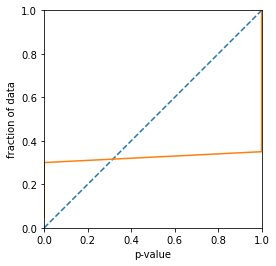

  0%|                                                                                           | 0/20 [00:00<?, ?it/s]C:\Users\siptest\anaconda3\envs\py36\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
  5%|████▏                                                                              | 1/20 [00:01<00:29,  1.54s/it]

P-value: 1.0
Test stat: -inf
Null dist: [-inf, -inf, -inf, -inf, -inf]


C:\Users\siptest\anaconda3\envs\py36\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
 10%|████████▎                                                                          | 2/20 [00:03<00:28,  1.57s/it]

P-value: 0.0
Test stat: -0.20923426131001047
Null dist: [-0.5698062357375901, -0.5535572310580684, -0.5735283677983936, -0.5532996499090147, -0.5729444598203823]


C:\Users\siptest\anaconda3\envs\py36\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
 15%|████████████▍                                                                      | 3/20 [00:04<00:27,  1.63s/it]

P-value: 0.0
Test stat: -0.21530390153191845
Null dist: [-0.5861820290786034, -0.6076895878079042, -0.6172451716547633, -0.5987569962863234, -0.6007397605341708]


C:\Users\siptest\anaconda3\envs\py36\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
 20%|████████████████▌                                                                  | 4/20 [00:06<00:25,  1.60s/it]

P-value: 0.0
Test stat: -0.09568724567791864
Null dist: [-0.45733452132555097, -0.45128689643096365, -0.4752598721694724, -0.46236713769759896, -0.44802411726172653]


C:\Users\siptest\anaconda3\envs\py36\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
 25%|████████████████████▊                                                              | 5/20 [00:08<00:23,  1.58s/it]

P-value: 1.0
Test stat: -inf
Null dist: [-inf, -inf, -inf, -inf, -inf]


C:\Users\siptest\anaconda3\envs\py36\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
 30%|████████████████████████▉                                                          | 6/20 [00:09<00:22,  1.59s/it]

P-value: 0.0
Test stat: -0.20934090541029216
Null dist: [-0.5827922198410007, -0.5522487832367629, -0.5661647596664487, -0.5733958834384978, -0.5983382267506103]


C:\Users\siptest\anaconda3\envs\py36\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
 35%|█████████████████████████████                                                      | 7/20 [00:11<00:20,  1.56s/it]

P-value: 0.0
Test stat: -0.18268060259193186
Null dist: [-0.4739028608219717, -0.47839412471911985, -0.4998335844581148, -0.4978697676640044, -0.479217345885041]


C:\Users\siptest\anaconda3\envs\py36\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
 40%|█████████████████████████████████▏                                                 | 8/20 [00:12<00:19,  1.59s/it]

P-value: 0.0
Test stat: -0.22527185048622383
Null dist: [-0.6184921069631282, -0.613950661296691, -0.6136912079899604, -0.6163262411391233, -0.6140087942334314]


C:\Users\siptest\anaconda3\envs\py36\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
 45%|█████████████████████████████████████▎                                             | 9/20 [00:14<00:17,  1.57s/it]

P-value: 1.0
Test stat: -inf
Null dist: [-inf, -inf, -inf, -inf, -inf]


C:\Users\siptest\anaconda3\envs\py36\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
 50%|█████████████████████████████████████████                                         | 10/20 [00:15<00:16,  1.61s/it]

P-value: 1.0
Test stat: -inf
Null dist: [-inf, -inf, -inf, -inf, -inf]


C:\Users\siptest\anaconda3\envs\py36\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
 55%|█████████████████████████████████████████████                                     | 11/20 [00:17<00:14,  1.62s/it]

P-value: 1.0
Test stat: -inf
Null dist: [-inf, -inf, -inf, -inf, -inf]


C:\Users\siptest\anaconda3\envs\py36\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
 60%|█████████████████████████████████████████████████▏                                | 12/20 [00:19<00:12,  1.60s/it]

P-value: 1.0
Test stat: -inf
Null dist: [-inf, -inf, -inf, -inf, -inf]


C:\Users\siptest\anaconda3\envs\py36\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
 65%|█████████████████████████████████████████████████████▎                            | 13/20 [00:20<00:10,  1.55s/it]

P-value: 0.0
Test stat: -0.23141735040911943
Null dist: [-0.5711465961692517, -0.5897246515715655, -0.589290763681134, -0.5802380576869377, -0.5994456629138398]


C:\Users\siptest\anaconda3\envs\py36\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
 70%|█████████████████████████████████████████████████████████▍                        | 14/20 [00:22<00:09,  1.61s/it]

P-value: 0.0
Test stat: -0.19324201555972975
Null dist: [-0.6009917874381057, -0.599852426540658, -0.6088488729119199, -0.6301206571704496, -0.6067174091743708]


C:\Users\siptest\anaconda3\envs\py36\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
 75%|█████████████████████████████████████████████████████████████▌                    | 15/20 [00:24<00:08,  1.73s/it]

P-value: 0.0
Test stat: -0.3676270005301604
Null dist: [-0.7257542031612729, -0.7185261330748742, -0.7300377424987015, -0.7294102630936126, -0.717769547048393]


C:\Users\siptest\anaconda3\envs\py36\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
 80%|█████████████████████████████████████████████████████████████████▌                | 16/20 [00:26<00:07,  1.85s/it]

P-value: 0.0
Test stat: -0.16252578352842406
Null dist: [-0.6083749727788449, -0.5810022705258565, -0.5890680045238281, -0.5885145001928912, -0.5960591527055118]


C:\Users\siptest\anaconda3\envs\py36\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
 85%|█████████████████████████████████████████████████████████████████████▋            | 17/20 [00:28<00:05,  1.83s/it]

P-value: 1.0
Test stat: -inf
Null dist: [-inf, -inf, -inf, -inf, -inf]


C:\Users\siptest\anaconda3\envs\py36\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:30<00:03,  1.91s/it]

P-value: 0.0
Test stat: -0.13813372685272624
Null dist: [-0.47922955788936983, -0.4695278529113244, -0.4644603708922477, -0.45481386849084415, -0.4611030732761048]


C:\Users\siptest\anaconda3\envs\py36\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
 95%|█████████████████████████████████████████████████████████████████████████████▉    | 19/20 [00:32<00:01,  1.92s/it]

P-value: 1.0
Test stat: -inf
Null dist: [-inf, -inf, -inf, -inf, -inf]


C:\Users\siptest\anaconda3\envs\py36\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:34<00:00,  1.71s/it]

P-value: 0.0
Test stat: -0.3093090141238619
Null dist: [-0.5586164165936689, -0.5988901393888222, -0.5661889620709711, -0.5708510520778982, -0.593025110224375]


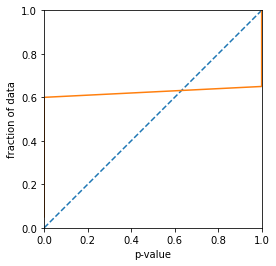

  0%|                                                                                           | 0/20 [00:00<?, ?it/s]C:\Users\siptest\anaconda3\envs\py36\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
  5%|████▏                                                                              | 1/20 [00:02<00:42,  2.23s/it]

P-value: 0.0
Test stat: -0.21873169570129225
Null dist: [-0.6706514086609265, -0.6700707419966033, -0.6528896107647617, -0.6413165023003604, -0.6511870828459418]


C:\Users\siptest\anaconda3\envs\py36\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
 10%|████████▎                                                                          | 2/20 [00:04<00:39,  2.20s/it]

P-value: 1.0
Test stat: -inf
Null dist: [-inf, -inf, -inf, -inf, -inf]


C:\Users\siptest\anaconda3\envs\py36\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
 15%|████████████▍                                                                      | 3/20 [00:06<00:37,  2.19s/it]

P-value: 0.0
Test stat: -0.22809310099724217
Null dist: [-0.6281625571631729, -0.6095786866062614, -0.6212562877929606, -0.6144341288669646, -0.6131447622490691]


C:\Users\siptest\anaconda3\envs\py36\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
 20%|████████████████▌                                                                  | 4/20 [00:08<00:33,  2.07s/it]

P-value: 1.0
Test stat: -inf
Null dist: [-inf, -inf, -inf, -inf, -inf]


C:\Users\siptest\anaconda3\envs\py36\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
 25%|████████████████████▊                                                              | 5/20 [00:10<00:29,  2.00s/it]

P-value: 1.0
Test stat: -inf
Null dist: [-inf, -inf, -inf, -inf, -inf]


C:\Users\siptest\anaconda3\envs\py36\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
 30%|████████████████████████▉                                                          | 6/20 [00:11<00:27,  1.95s/it]

P-value: 1.0
Test stat: -inf
Null dist: [-inf, -inf, -inf, -inf, -inf]


C:\Users\siptest\anaconda3\envs\py36\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
 35%|█████████████████████████████                                                      | 7/20 [00:13<00:25,  1.92s/it]

P-value: 0.0
Test stat: -0.1926535451139073
Null dist: [-0.6433317563486166, -0.6473988580639225, -0.6482924795949109, -0.6569560631797428, -0.639175478145849]


C:\Users\siptest\anaconda3\envs\py36\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
 40%|█████████████████████████████████▏                                                 | 8/20 [00:15<00:22,  1.89s/it]

P-value: 0.0
Test stat: -0.2546978554960309
Null dist: [-0.6454372548818397, -0.6275928602587231, -0.6205540801854219, -0.627156942287473, -0.6350784353183436]


C:\Users\siptest\anaconda3\envs\py36\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
 45%|█████████████████████████████████████▎                                             | 9/20 [00:17<00:21,  1.98s/it]

P-value: 0.0
Test stat: -0.3011671711117586
Null dist: [-0.6316265468914778, -0.6372209797544715, -0.6461036846694274, -0.6541101651339074, -0.6459976662460928]


C:\Users\siptest\anaconda3\envs\py36\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
 50%|█████████████████████████████████████████                                         | 10/20 [00:20<00:21,  2.13s/it]

P-value: 1.0
Test stat: -inf
Null dist: [-inf, -inf, -inf, -inf, -inf]


C:\Users\siptest\anaconda3\envs\py36\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
 55%|█████████████████████████████████████████████                                     | 11/20 [00:22<00:19,  2.20s/it]

P-value: 0.0
Test stat: -0.14847412632974305
Null dist: [-0.574134537407929, -0.5564345443337628, -0.5524339988356244, -0.5447447559615051, -0.5606911690384004]


C:\Users\siptest\anaconda3\envs\py36\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
 60%|█████████████████████████████████████████████████▏                                | 12/20 [00:24<00:17,  2.14s/it]

P-value: 0.0
Test stat: -0.19699322109348394
Null dist: [-0.5670463438686598, -0.5555805931569786, -0.5637845291887407, -0.5313023910911511, -0.568436406725505]


C:\Users\siptest\anaconda3\envs\py36\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
 65%|█████████████████████████████████████████████████████▎                            | 13/20 [00:26<00:15,  2.15s/it]

P-value: 1.0
Test stat: -inf
Null dist: [-inf, -inf, -inf, -inf, -inf]


C:\Users\siptest\anaconda3\envs\py36\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
 70%|█████████████████████████████████████████████████████████▍                        | 14/20 [00:29<00:12,  2.17s/it]

P-value: 1.0
Test stat: -inf
Null dist: [-inf, -inf, -inf, -inf, -inf]


C:\Users\siptest\anaconda3\envs\py36\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
 75%|█████████████████████████████████████████████████████████████▌                    | 15/20 [00:31<00:10,  2.10s/it]

P-value: 1.0
Test stat: -inf
Null dist: [-inf, -inf, -inf, -inf, -inf]


C:\Users\siptest\anaconda3\envs\py36\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
 80%|█████████████████████████████████████████████████████████████████▌                | 16/20 [00:32<00:08,  2.06s/it]

P-value: 0.0
Test stat: -0.17669880259004334
Null dist: [-0.5480860042601607, -0.5352613017410371, -0.5446591173423155, -0.5431117589186539, -0.5336980144026089]


C:\Users\siptest\anaconda3\envs\py36\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
 85%|█████████████████████████████████████████████████████████████████████▋            | 17/20 [00:34<00:06,  2.02s/it]

P-value: 0.0
Test stat: -0.10554012270043356
Null dist: [-0.5074180260349466, -0.5093030909072804, -0.4977291134656136, -0.48831446016533736, -0.5072514383028797]


C:\Users\siptest\anaconda3\envs\py36\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:36<00:04,  2.01s/it]

P-value: 0.0
Test stat: -0.3570898140045309
Null dist: [-0.7269983928442636, -0.7246363910473962, -0.7325135780515989, -0.7357914393406034, -0.7241067293894046]


C:\Users\siptest\anaconda3\envs\py36\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
 95%|█████████████████████████████████████████████████████████████████████████████▉    | 19/20 [00:38<00:02,  2.02s/it]

P-value: 0.0
Test stat: -0.24052910992304416
Null dist: [-0.6683911350305496, -0.6444183947522951, -0.669639108741505, -0.66014783331261, -0.6588687649253977]


C:\Users\siptest\anaconda3\envs\py36\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:40<00:00,  2.05s/it]

P-value: 0.0
Test stat: -0.21836017111756267
Null dist: [-0.6139650554721662, -0.5986025205936482, -0.6106064637318757, -0.5843316600093011, -0.5977330655081243]


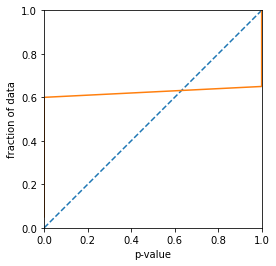

In [39]:
power, pvalues_list = estimate_power(SIMULATIONS[0], n_jobs=4)

In [40]:
import matplotlib.pyplot as plt
def plot_power2(): 
    
    sim_title = [
        "Linear", 
        #"Independence"
    ]
    sim = multimodal_independence
    power = np.genfromtxt('C:/Users/siptest/Desktop/NDD/linear_honest_3-31.csv',
                                      delimiter=',')
    plt.plot(power)
    plt.yticks([0, 1])
    plt.axhline(y=0.05, color='b', linestyle='--')
    positions = (0, 3, 5)
    labels = ("100", "300", "500")
    plt.xticks(positions, labels)
    plt.xlabel("Sample Size")
    plt.ylabel("Mean Power from 100 Reps")
    plt.savefig("C:/Users/siptest/Desktop/NDD/linear_honest_3-31.jpg", bbox_inches='tight')
    

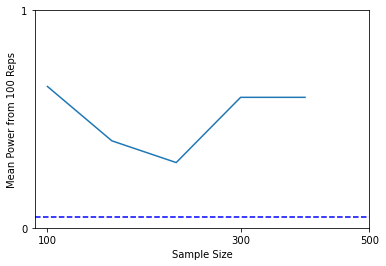

In [41]:
plot_power2()